In [1]:
import numpy as np
import matplotlib.pyplot as plt
import umap
import math
import numpy.linalg as la
#Fashion mnist
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import model_selection
from sklearn import linear_model, ensemble, tree, neighbors, svm
from mnist.loader import MNIST
from sklearn.decomposition import PCA

In [2]:
print("Fetching Fashion-Mnist")
print("=========================")
mndata = MNIST('../fashion-mnist/data/fashion') #added path extension for new file structure
train, train_labels = mndata.load_training()
test, test_labels = mndata.load_testing()
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.hstack([train_labels, test_labels])
classes = [
    'T-shirt/top',
    'Trouser', 
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']
print("Fashion-Mnist loaded")
print ("=========================")

Fetching Fashion-Mnist
Fashion-Mnist loaded


In [3]:
from __future__ import print_function
import cv2 as cv
import numpy as np
import argparse

## Completion bar 

In [4]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

## Rotation scheme through opencv


In [5]:
def rotate(image, deg):
    src=image
    srcTri = np.array( [[0, 0], [src.shape[1] - 1, 0], [0, src.shape[0] - 1]] ).astype(np.float32)
    dstTri = np.array( [[0, src.shape[1]*0.33], [src.shape[1]*0.85, src.shape[0]*0.25], [src.shape[1]*0.15, src.shape[0]*0.7]] ).astype(np.float32)
    warp_mat = cv.getAffineTransform(srcTri, dstTri)
    warp_dst = cv.warpAffine(src, warp_mat, (src.shape[1], src.shape[0]))

    # Rotating the image after Warp
    center = (warp_dst.shape[1]//2, warp_dst.shape[0]//2)
    angle = deg
    scale = 1

    rot_mat = cv.getRotationMatrix2D( center, angle, scale )
    warp_rotate_dst = cv.warpAffine(src, rot_mat, (src.shape[1], src.shape[0]))
    tau=.1
    for j in range(warp_rotate_dst.shape[0]):
        for k in range(warp_rotate_dst.shape[0]):
            if warp_rotate_dst[j][k]<tau:
                warp_rotate_dst[j][k]=np.rint(warp_rotate_dst[j][k])
    return warp_rotate_dst

## Scrambling the data
During this step its important to ensure that we end up with a set of rotated images such that they have uniform matrix dimensions 


In [6]:
#Generate list of rotations to randomly choose from 
N=10
phi = np.linspace(-N,N,1000)
phi = phi%(2*math.pi)
phi=np.degrees(phi)
phi=(np.floor(phi))
phi=phi.astype('int32')
print(np.random.choice(phi))

r_data=[]
for i in range(np.shape(data)[0]):
    theta=np.random.choice(phi)
    #print(i,theta)
    r_data.append(rotate(np.reshape(data[i],(28,28)),theta))
    update_progress(i / np.shape(data)[0])
    

Progress: [####################] 100.0%


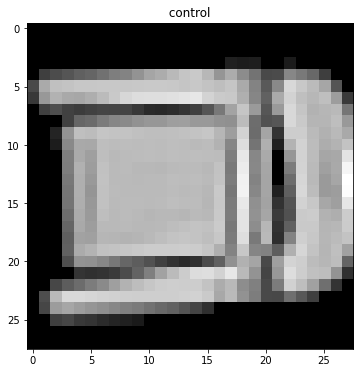

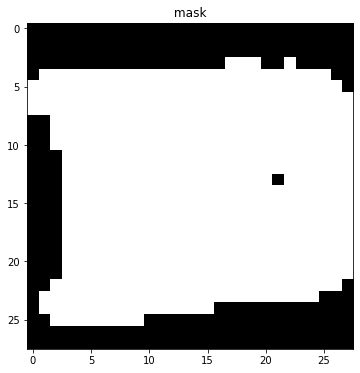

In [44]:
#manually create a small  binary mask: 
n=5
X = np.reshape(r_data[n],(28,28))
Y=np.zeros((28,28))
for i in range(28):
    for j in range(28):
        if X[i][j]>.025:
            Y[i][j]=1
#small corrections
for i in range(28):
    for j in range(28):
        if i==27or j==27:
            continue
        if Y[i-1][j]+Y[i+1][j]+Y[i][j-1]+Y[i][j+1]==3:
            Y[i][j]=1
            
fig = plt.figure( figsize=(8, 6))
plt.title(" control ")
plt.imshow(np.reshape(r_data[n],(28,28)), cmap='gray')
plt.show()
fig = plt.figure( figsize=(8, 6))
plt.title(" mask ")
plt.imshow(Y, cmap='gray')
plt.show()

(2, 536)


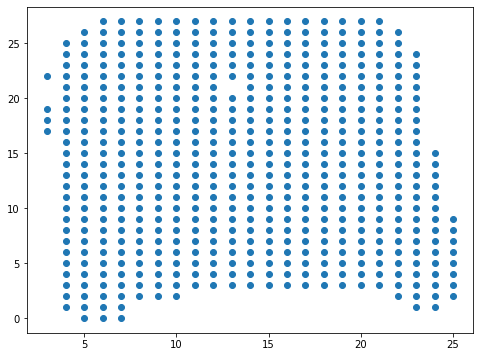

In [45]:
#Create point list for 2d pca
x=[]
y=[]
for i in range(28):
    for j in range(28):
        if Y[i][j]==1:
            x.append(i)
            y.append(j)
#x.reverse()
#y.reverse()
A=np.vstack((x,y))
print(np.shape(A))
fig = plt.figure( figsize=(8, 6))
plt.plot(x,y,'o')


In [46]:
def compute_principal_vectors(A):
    #compute mask
    n=np.shape(A)[0]
    Y=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if A[i][j]>.025:
                Y[i][j]=1
    #small corrections
    for i in range(n):
        for j in range(n):
            if i==27or j==27:
                continue
            #Check neighbors
            if Y[i-1][j]+Y[i+1][j]+Y[i][j-1]+Y[i][j+1]==3:#try maxing or averaging over threshold 
                Y[i][j]=1
    #Create point list for 2d pca
    x=[]
    y=[]
    for i in range(n):
        for j in range(n):
            if Y[i][j]==1:
                x.append(i)
                y.append(j)
    X=np.vstack((x,y))
    C=1/n*X@X.T
    w,v=la.eig(C)
    Vplus=np.asarray([C[0][0]+C[0][1]-w[0],C[1][1]+C[0][1]-w[0]])
    Vminus=np.asarray([C[0][0]+C[0][1]-w[1],C[1][1]+C[0][1]-w[1]])
    Uplus=Vplus / np.sqrt(np.sum(Vplus**2))
    Uminus=Vminus / np.sqrt(np.sum(Vminus**2))
    Rtrans=np.column_stack(((Uplus),(Uminus)))
    return Rtrans


In [47]:
def plot_pc_vectors(R):
    
    fig = plt.figure( figsize=(8, 6))
    plt.plot(x,y,'o')
    #print(xbar,ybar)

    #eig_vec1 = np.asarray([majoraxis, 0])
    #eig_vec2 = [0, minoraxis]
    origin = [15, 15]
    plt.quiver(*origin, R[0][0],R[0][1],  color=['r'], scale=1)
    plt.quiver(*origin, R[1][0],R[1][1],color=['y'], scale=1)

    origin = [15, 15]
    plt.quiver(*origin, -R[0][0],-R[0][1],  color=['r'], scale=1)
    plt.quiver(*origin, -R[1][0],-R[1][1],color=['y'], scale=1)
    plt.show()

    print(np.cross(Uplus,Uminus))

(2, 2)
[[4331.35714286 3667.25      ]
 [3667.25       4863.89285714]]
[0.68102264 0.73226236]
[-0.73226236  0.68102264]


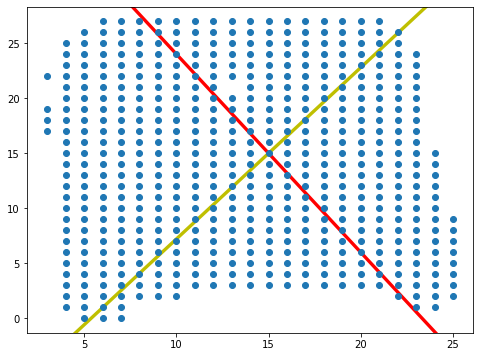

1.0


In [48]:
A=np.vstack((x,y))
C=1/28*A@A.T
print(np.shape(C))
print(C)
w,v=la.eig(C)
#print(w)
#print(v)
Vplus=np.asarray([C[0][0]+C[0][1]-w[0],C[1][1]+C[0][1]-w[0]])
Vminus=np.asarray([C[0][0]+C[0][1]-w[1],C[1][1]+C[0][1]-w[1]])
#print(Vplus)
#print(Vminus)
Uplus=Vplus / np.sqrt(np.sum(Vplus**2))
Uminus=Vminus / np.sqrt(np.sum(Vminus**2))
print(Uplus)
print(Uminus)

R=compute_principal_vectors(np.reshape(r_data[n],(28,28)))
plot_pc_vectors(R)


In [49]:
Rtrans=np.column_stack(((Uplus),(Uminus)))
Rtrans

array([[ 0.68102264, -0.73226236],
       [ 0.73226236,  0.68102264]])

In [50]:
theta=math.degrees(math.acos(Rtrans[0][0]))
theta

47.07639241441362

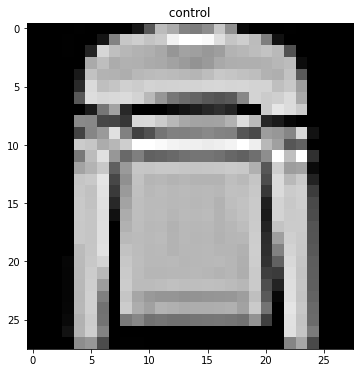

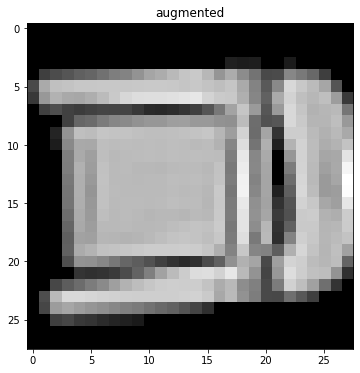

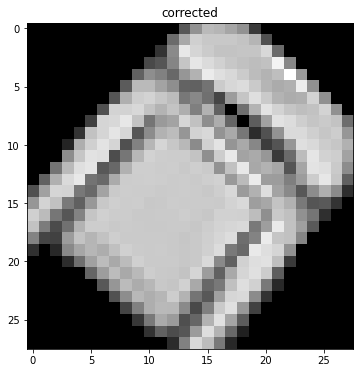

In [51]:
#control

fig = plt.figure( figsize=(8, 6))
plt.title(" control ")
plt.imshow(np.reshape(data[n],(28,28)), cmap='gray')
plt.show()
#Augmented

fig = plt.figure( figsize=(8, 6))
plt.title("augmented")
plt.imshow(r_data[n], cmap='gray')
plt.show()
#correction: 
#target=np.argmin(norms)
fig = plt.figure( figsize=(8, 6))
plt.title("corrected")
plt.imshow(rotate(r_data[n],theta), cmap='gray')
plt.show()


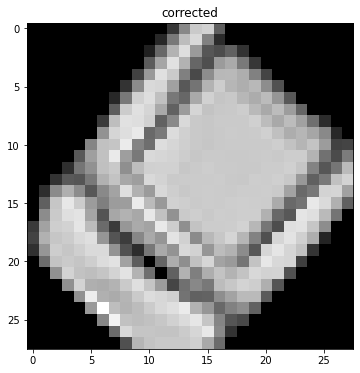

In [52]:
#pick the best of the four: 
right_rotations=[]
for i in range(4):
    right_rotations.append(rotate(r_data[n],theta+90*i))
final_norms=[]
for i in range(4):
    final_norms.append(la.norm(compute_principal_vectors(right_rotations[i])-np.eye(2)))
    
fig = plt.figure( figsize=(8, 6))
plt.title("corrected")
plt.imshow(right_rotations[np.argmax(final_norms)], cmap='gray')
plt.show()

0


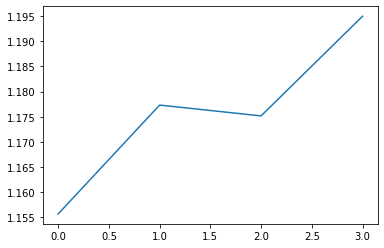

In [38]:
plt.plot(final_norms)
print(np.argmin(final_norms))

Brute Force approach instead of R

In [39]:
t=r_data[1]
norms=[]
#n=r_data[i].shape[0]
I=np.eye(2,2)
for i in range(0,360):
    t=rotate(Rtrans,i)
    
    norms.append(la.norm(t-I))
    #Forcing 
    #norms.append(la.norm(U-U_control))
    
    #Experimental difference criteria
    #norms.append(la.norm(U-I))
    #norms.append(la.norm(U-I_ex))

331


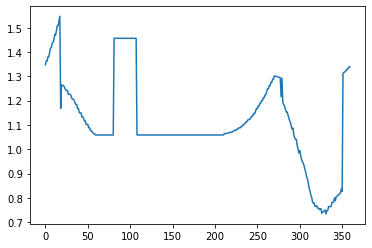

In [40]:
plt.plot(norms)
print(np.argmin(norms))

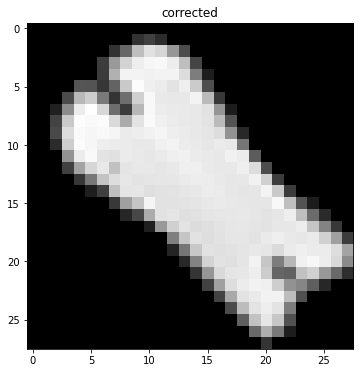

In [25]:
target=np.argmax(norms)-180
fig = plt.figure( figsize=(8, 6))
plt.title("corrected")
plt.imshow(rotate(r_data[n],93), cmap='gray')
plt.show()

/tmp/ipykernel_3488740/1202508206.py:18: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(surf)


<Figure size 432x288 with 0 Axes>

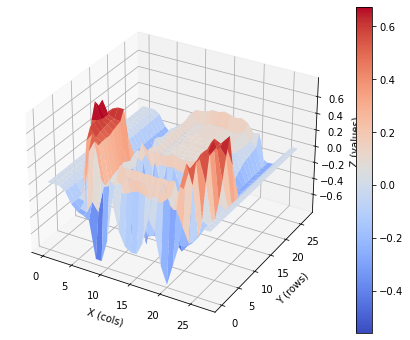

In [59]:
def surface_plot (matrix, **kwargs):
    # acquire the cartesian coordinate matrices from the matrix
    # x is cols, y is rows
    (x, y) = np.meshgrid(np.arange(matrix.shape[0]), np.arange(matrix.shape[1]))
    fig = plt.figure()
    fig = plt.figure( figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, matrix, **kwargs)
    return (fig, ax, surf)

# m.shape must be (10,10)
m = np.fromfunction(lambda x, y: np.sin(np.sqrt(x**2 + y**2)), (10, 10))
X = np.reshape(data[1],(28,28))

(fig, ax, viridian) = surface_plot(X, cmap=plt.cm.coolwarm)


fig.colorbar(surf)

ax.set_xlabel('X (cols)')
ax.set_ylabel('Y (rows)')
ax.set_zlabel('Z (values)')

plt.show()

16.15549442140351 1.0
0.5 13.5


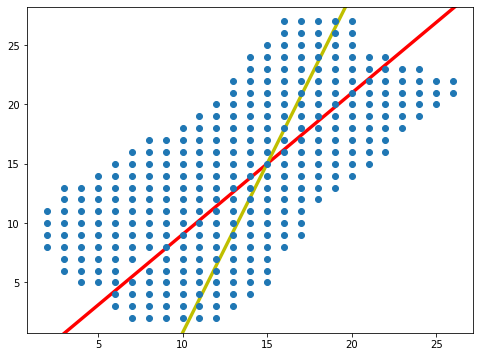

In [249]:
 A=np.vstack((x,y))
sumx=0
sumy=0
sumxx=0
sumyy=0
sumxy=0
npix=0
# scan the image (nLength and nHeight are the dimensions of the image)
for i in range(2):
    for j in range(28):
        if (A[i][j]): #true if we are i the region of interest
            sumx+=i; 
            sumy+=j; 
            sumxx+=i*i
            sumyy+=j*j; 
            sumxy+=i*j; 
            npix+=1
# baricenter
xbar = (sumx)/npix;
ybar = (sumy)/npix;
# variances and covariance
varx = sumxx/npix - xbar*xbar;
vary = sumyy/npix - ybar*ybar;
covxy = sumxy/npix - xbar*ybar;
sumvars = varx + vary;
diffvars = varx - vary;
discriminant = diffvars*diffvars + 4*covxy*covxy;
sqrtdiscr = math.sqrt(discriminant);
# eigenvalues
lambdaplus = (sumvars + sqrtdiscr)/2;
lambdaminus = (sumvars - sqrtdiscr)/2;
#eigenvectors - these are the components of the two vectors
aplus = varx + covxy - lambdaminus;
bplus = vary + covxy - lambdaminus;
aminus = varx + covxy - lambdaplus;
bminus = vary + covxy - lambdaplus;
# normalizing the vectors

denomPlus = math.sqrt(aplus*aplus + bplus*bplus);
denomMinus= math.sqrt(aminus*aminus + bminus*bminus);
aParallel = aplus/denomPlus;
bParallel = bplus/denomPlus;
aNormal = aminus/denomMinus;
bNormal = bminus/denomMinus;
# semi axes
k = 2 # scale factor
majoraxis = k*math.sqrt(lambdaplus);
minoraxis = k*math.sqrt(lambdaminus);
print(majoraxis,minoraxis)

fig = plt.figure( figsize=(8, 6))
plt.plot(x,y,'o')
print(xbar,ybar)

#eig_vec1 = np.asarray([majoraxis, 0])
#eig_vec2 = [0, minoraxis]
origin = [15, 15]
plt.quiver(*origin, majoraxis,ybar,  color=['r'], scale=1)
plt.quiver(*origin, xbar,minoraxis  ,color=['y'], scale=1)

eig_vec1 = np.asarray([-majoraxis, 0])
eig_vec2 = [0, -minoraxis]
origin = [15, 15]
plt.quiver(*origin, -majoraxis,-ybar,  color=['r'], scale=1)
plt.quiver(*origin, -xbar,-minoraxis,  color=['y'], scale=1)
plt.show()

PCA step

In [209]:
x=1
X=np.reshape(r_data[1],(28,28))
pca = PCA(n_components=2)
pca.fit(X)
n_samples = X.shape[0]
# We center the data and compute the sample covariance matrix.
X -= np.mean(X, axis=0)
cov_matrix = np.dot(X.T, X) / n_samples

print(np.shape(pca.components_[0]))

for eigenvector in pca.components_:
    print(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))
#Augmented
"""
fig = plt.figure( figsize=(8, 6))
plt.title("augmented")
plt.imshow(r_data[x], cmap='viridis')
plt.show()

"""
fig = plt.figure( figsize=(8, 6))
plt.plot(x,y,'o')
print(xbar,ybar)
eigen_vectors = np.array([[majoraxis, 0], [0, minoraxis]])
eig_vec1 = eigen_vectors[:,0]
eig_vec2 = eigen_vectors[:,1]
origin = [13, 13]
plt.quiver(*origin, *eig_vec1,  color=['r'], scale=1)
plt.quiver(*origin, *eig_vec2,  color=['y'], scale=1)
eigen_vectors = np.array([[-majoraxis, 0], [0, -minoraxis]])
eig_vec3 = eigen_vectors[:,0]
eig_vec4 = eigen_vectors[:,1]
origin = [13, 13]
plt.quiver(*origin, *eig_vec3,  color=['r'], scale=1)
plt.quiver(*origin, *eig_vec4,  color=['y'], scale=1)
plt.show()

(28,)
1.0758115871756
0.475357501400952


'\nfig = plt.figure( figsize=(8, 6))\nplt.title("augmented")\nplt.imshow(r_data[x], cmap=\'viridis\')\nplt.show()\n\n'

In [69]:
import cv2
image = np.reshape(data[1],(28,28))

image = cv2.resize(image, (image.shape[1] // 4, image.shape[0] // 4))
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(image, (5, 5), 0)

thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

max_area = 0
best_cnt = None
for counter in contours:
    area = cv2.contourArea(counter)
    if area > 1000:
        if area > max_area:
            max_area = area
            best_cnt = counter

mask = np.zeros((28,28), np.uint8)

cv2.drawContours(mask, [best_cnt], 0, 255, -1)
cv2.drawContours(mask, [best_cnt], 0, 0, 2)

cv2.imwrite('mask_jigsaw.jpg', mask)

cv2.imshow("Image Mask", mask)
cv2.waitKey(0)

error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/thresh.cpp:1674: error: (-215:Assertion failed) src.type() == CV_8UC1 in function 'adaptiveThreshold'
